In [ ]:

# !git clone https://github.com/JunkyByte/easy_ViTPose.git
# !cd easy_ViTPose/ && pip install -r requirements.txt && pip install -e .
!pip install huggingface_hub

In [4]:
#@title Choose model and run this cell

MODEL_SIZE = 'h'  #@param ['s', 'b', 'l', 'h']
YOLO_SIZE = 's'  #@param ['s', 'n']
DATASET = 'coco_25'  #@param ['coco_25', 'coco', 'wholebody', 'mpii', 'aic', 'ap10k', 'apt36k']
ext = '.pth'
ext_yolo = '.pt'

import os
from huggingface_hub import hf_hub_download
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
# model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
# yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)
model_path = '/home/salam/frontal_gait/vitpose-h-coco_25.pth'
yolo_path = '/home/salam/frontal_gait/yolov8s.pt'

In [5]:
# If you get an error from PIL restart environment and rerun this cell to update packages version
from easy_ViTPose.easy_ViTPose.inference import VitInference
model = VitInference(model_path, yolo_path, MODEL_SIZE,
                     dataset=DATASET, yolo_size=320, is_video=False)

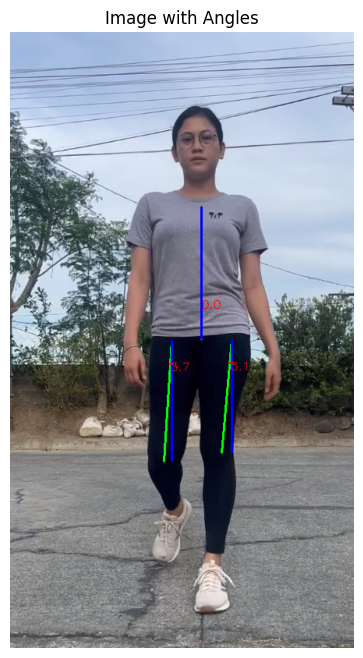

In [5]:
import numpy as np
import cv2
# Specify the file path of your image
file_path = '/home/salam/frontal_gait/image2.png'
# Load the image using OpenCV
img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
# Check if the image has 4 channels (e.g., RGBA) and convert to 3 channels if needed
if img.shape[2] == 4:
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
# Run inference to get frame_keypoints in (y, x, confidence) format
frame_keypoints = model.inference(img)[0]
# Extract coordinates for points
neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))  # Neck point
hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))  # Hip point (reference)
left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))  # Left hip
right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))  # Right hip
left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))  # Left knee
right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))  # Right knee
# Define vertical line points for neck and knees
vertical_line_neck_point = (hip_point[0], neck_point[1])  # Vertical point from hip towards neck
left_vertical_line_point = (left_hip_point[0], left_knee_point[1])  # Vertical point from left hip towards left knee
right_vertical_line_point = (right_hip_point[0], right_knee_point[1])  # Vertical point from right hip towards right knee
# Draw the lines: hip to neck, hips to knees, and vertical lines
cv2.line(img, hip_point, neck_point, (0, 255, 0), 2)  # Green line from hip to neck
cv2.line(img, left_hip_point, left_knee_point, (0, 255, 0), 2)  # Green line from left hip to left knee
cv2.line(img, right_hip_point, right_knee_point, (0, 255, 0), 2)  # Green line from right hip to right knee
# Draw vertical lines
cv2.line(img, hip_point, vertical_line_neck_point, (255, 0, 0), 2)  # Blue vertical line for neck
cv2.line(img, left_hip_point, left_vertical_line_point, (255, 0, 0), 2)  # Blue vertical line for left knee
cv2.line(img, right_hip_point, right_vertical_line_point, (255, 0, 0), 2)  # Blue vertical line for right knee

def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)

def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 0, 255), thickness=2):
    """
    Draw a semicircle to indicate the angle between two lines and add the angle value.

    Args:
        img: Image to draw on
        vertex: Point where the two lines meet (angle vertex)
        point1: First point to define the first line
        point2: Second point to define the second line
        radius: Radius of the semicircle
        color: Color of the semicircle (BGR format)
        thickness: Thickness of the semicircle line
    """
    # Calculate vectors
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)

    # Calculate angles
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])

    # Ensure angle2 > angle1
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1

    # Draw arc
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))

    # Draw the arc
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)

    # Calculate middle angle for text placement
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))

    return (text_x, text_y)

# Calculate angles
neck_angle_degrees = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
left_angle_degrees = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
right_angle_degrees = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

# Draw angle arcs and add text
# Neck angle
text_pos = draw_angle_arc(img, hip_point, neck_point, vertical_line_neck_point)
cv2.putText(img, f"{neck_angle_degrees:.1f}", text_pos,
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Left knee angle
text_pos = draw_angle_arc(img, left_hip_point, left_knee_point, left_vertical_line_point)
cv2.putText(img, f"{left_angle_degrees:.1f}", text_pos,
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Right knee angle
text_pos = draw_angle_arc(img, right_hip_point, right_knee_point, right_vertical_line_point)
cv2.putText(img, f"{right_angle_degrees:.1f}", text_pos,
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

import matplotlib.pyplot as plt

# Display the image
plt.figure(figsize=(10, 8))  # Optional: set figure size
plt.imshow(img[..., ::-1])  # Convert BGR to RGB
plt.axis('off')  # Hide axis
plt.title('Image with Angles')  # Optional: add a title
plt.show()

In [43]:
import numpy as np
import cv2
import csv
from tqdm.auto import tqdm
from PIL import Image
def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)


def is_between_vertical_lines(knee_point, left_hip_vertical, right_hip_vertical):
    # Check if the knee x-coordinate is between the x-coordinates of the two vertical lines
    x_min = min(left_hip_vertical[0], right_hip_vertical[0])
    x_max = max(left_hip_vertical[0], right_hip_vertical[0])
    return x_min <= knee_point[0] <= x_max


def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 0, 255), thickness=2):
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)
    
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1
    
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))
    
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)
    
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))
    
    return (text_x, text_y)

def calculate_text_parameters(frame_width, frame_height):
    """
    Calculate font size and thickness based on frame dimensions
    """
    # Calculate the diagonal size of the frame
    diagonal = np.sqrt(frame_width**2 + frame_height**2)
    
    # Scale font size based on diagonal (empirically determined ratios)
    font_scale = diagonal / 2000.0  # Adjust this divisor to change the base scale
    thickness = max(1, int(diagonal / 1000.0))  # Adjust this divisor to change the base thickness
    
    # Parameters for different text elements
    frame_number_params = {
        'font_scale': font_scale * 4,  # Slightly larger for frame number
        'thickness': thickness + 1,
        'margin_x': int(frame_width * 0.02),  # 2% margin from left
        'margin_y': int(frame_height * 0.05)   # 5% margin from top
    }
    
    angle_text_params = {
        'font_scale': font_scale * 0.8,  # Slightly smaller for angle values
        'thickness': thickness
    }
    
    line_thickness = max(1, int(diagonal / 800.0))  # For lines and arcs
    
    return frame_number_params, angle_text_params, line_thickness

def process_video(input_path, output_path, csv_path, model,DcctorIsLeft=True):
    # Open the video file
    cap = cv2.VideoCapture(input_path)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(f"Total frames: {total_frames}")
    # print(f"fps: {fps}")
    # Calculate text parameters based on frame size
    frame_number_params, angle_text_params, line_thickness = calculate_text_parameters(frame_width, frame_height)
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    # Set up video writer
    # try:
    #     fourcc = cv2.VideoWriter_fourcc(*'XVID')
    #     out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
        
    #     if not out.isOpened():
    #         raise Exception("XVID codec failed")
    # except:
    #     # print("Error opening output video file")
    #     return        
    # except Exception as e:
    #     try:
    #         fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #         out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
            
    #         if not out.isOpened():
    #             raise Exception("MP4V codec failed")
                
    #     except Exception as e:
    #         fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #         out = cv2.VideoWriter(output_path.replace('.mp4', '.avi'), 
    #                             fourcc, fps, (frame_width, frame_height))
    
    # Create CSV file and write header
    with open(csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Frame', 'Neck_Angle', 'Left_Knee_Angle', 'Right_Knee_Angle'])
        
        frame_number = 0
        pbar = tqdm(total=total_frames, desc="Processing Video", unit="frame")
        # print("started processing")
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            
            # if frame_number % 50 == 0:
            #     print(f"processing frame {frame_number}")
            # Add frame number with dynamic font size and position
            cv2.putText(frame, 
                       f"Frame: {frame_number}", 
                       (frame_number_params['margin_x'], frame_number_params['margin_y']),
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       frame_number_params['font_scale'], 
                       (255, 255, 255), 
                       frame_number_params['thickness'])
            
            if len(frame.shape) > 2 and frame.shape[2] == 4:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
            
            try:
                frame_keypoints = model.inference(frame)
            except Exception as e:
                # print(f"Error processing frame {frame_number}: {str(e)}")
                continue

            final_frame_keypoints = frame_keypoints[1]
            # print(frame_keypoints)

            if DcctorIsLeft:
                if frame_keypoints[1][0][1]>frame_keypoints[0][0][1]:
                    final_frame_keypoints = frame_keypoints[1]
                else:
                    final_frame_keypoints = frame_keypoints[0]
            else:
                if frame_keypoints[1][0][1]<frame_keypoints[0][0][1]:
                    final_frame_keypoints = frame_keypoints[1]
                else:
                    final_frame_keypoints = frame_keypoints[0]

            frame_keypoints= final_frame_keypoints
            try:
                # Extract coordinates for points
                neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))
                hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))
                left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))
                right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))
                left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))
                right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))
                
                # Define vertical line points
                vertical_line_neck_point = (hip_point[0], neck_point[1])
                left_vertical_line_point = (left_hip_point[0], left_knee_point[1])
                right_vertical_line_point = (right_hip_point[0], right_knee_point[1])
                
                # Draw the lines with dynamic thickness
                cv2.line(frame, hip_point, neck_point, (0, 255, 0), line_thickness)
                cv2.line(frame, left_hip_point, left_knee_point, (0, 255, 0), line_thickness)
                cv2.line(frame, right_hip_point, right_knee_point, (0, 255, 0), line_thickness)
                
                # Draw vertical lines
                cv2.line(frame, hip_point, vertical_line_neck_point, (255, 0, 0), line_thickness)
                cv2.line(frame, left_hip_point, left_vertical_line_point, (255, 0, 0), line_thickness)
                cv2.line(frame, right_hip_point, right_vertical_line_point, (255, 0, 0), line_thickness)
                
                # Calculate angles
                neck_angle = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
                left_angle = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
                right_angle = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

                # Adjust angle if greater than 180
                if neck_angle> 180:
                    neck_angle= 360 - neck_angle
                if left_angle > 180:
                    left_angle = 360 -left_angle
                if right_angle > 180:
                    right_angle = 360 - right_angle

                # Adjust angle sign based on the knee's position relative to the vertical lines
                left_hip_vertical = (left_hip_point[0], left_knee_point[1])
                right_hip_vertical = (right_hip_point[0], right_knee_point[1])

                # For left knee
                if is_between_vertical_lines(left_knee_point, left_hip_vertical, right_hip_vertical):
                    left_angle = -left_angle

                # For right knee
                if is_between_vertical_lines(right_knee_point, left_hip_vertical, right_hip_vertical):
                    right_angle = -right_angle
                
                # Draw angle arcs and add text with dynamic size
                radius = int(min(frame_width, frame_height) * 0.05)  # Dynamic radius based on frame size
                text_pos = draw_angle_arc(frame, hip_point, neck_point, vertical_line_neck_point, 
                                        radius=radius, thickness=line_thickness)
                cv2.putText(frame, f"{neck_angle:.1f}", text_pos,
                           cv2.FONT_HERSHEY_SIMPLEX, 
                           angle_text_params['font_scale'], 
                           (255, 255, 255), 
                           angle_text_params['thickness'])
                
                text_pos = draw_angle_arc(frame, left_hip_point, left_knee_point, left_vertical_line_point, 
                                        radius=radius, thickness=line_thickness)
                text_pos = (left_hip_point[0] + 10, left_hip_point[1] + 10)  # Use knee point + 10
                cv2.putText(frame, f"{left_angle:.1f}", text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1,  # Font scale equivalent to size 16
                        (255, 255, 255),  # Navy blue in BGR 
                        2)  # Thickness
                
                text_pos = draw_angle_arc(frame, right_hip_point, right_knee_point, right_vertical_line_point, 
                                        radius=radius, thickness=line_thickness)
                text_pos = (right_knee_point[0] + 10, right_knee_point[1] + 10)  # Use knee point + 10
                cv2.putText(frame, f"{right_angle:.1f}", text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        1,  # Font scale equivalent to size 16
                        (255, 255, 255),  # Navy blue in BGR (139, 69, 19)
                        2)  # Thickness
                
                csvwriter.writerow([frame_number, neck_angle, left_angle, right_angle])
                
            except (IndexError, ValueError) as e:
                csvwriter.writerow([frame_number, None, None, None])
            frame_number += 1
            out.write(frame)
            pbar.update(1)
        
        pbar.close()
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
input_video_path = '/home/salam/frontal_gait/videos/two_person_3.mp4'
file_name = input_video_path.split('/')[-1].split('.')[0]
output_video_path = f'/home/salam/frontal_gait/videos/{file_name}_oF.mp4'
csv_output_path = f'/home/salam/frontal_gait/csvs/{file_name}.csv'

process_video(input_video_path, output_video_path, csv_output_path, model)

Processing Video:   0%|          | 0/299 [00:00<?, ?frame/s]

In [ ]:
import numpy as np
import cv2
import csv
from tqdm.auto import tqdm
from PIL import Image


def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)


def is_between_vertical_lines(knee_point, left_hip_vertical, right_hip_vertical):
    x_min = min(left_hip_vertical[0], right_hip_vertical[0])
    x_max = max(left_hip_vertical[0], right_hip_vertical[0])
    return x_min <= knee_point[0] <= x_max


def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 255, 0), thickness=2):
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)
    
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1
    
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))
    
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)
    
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))
    
    return (text_x, text_y)


def calculate_text_parameters(frame_width, frame_height):
    diagonal = np.sqrt(frame_width**2 + frame_height**2)
    font_scale = diagonal / 2000.0
    thickness = max(1, int(diagonal / 1000.0))
    frame_number_params = {
        'font_scale': font_scale * 4,
        'thickness': thickness + 1,
        'margin_x': int(frame_width * 0.02),
        'margin_y': int(frame_height * 0.05)
    }
    angle_text_params = {
        'font_scale': font_scale * 0.8,
        'thickness': thickness
    }
    line_thickness = max(1, int(diagonal / 800.0))
    return frame_number_params, angle_text_params, line_thickness


def process_video(input_path, output_path, csv_path, model, DcctorIsLeft=True):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_number_params, angle_text_params, line_thickness = calculate_text_parameters(frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    with open(csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Frame', 'Neck_Angle', 'Left_Knee_Angle', 'Right_Knee_Angle'])
        frame_number = 0
        pbar = tqdm(total=total_frames, desc="Processing Video", unit="frame")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            cv2.putText(frame, 
                       f"Frame: {frame_number}", 
                       (frame_number_params['margin_x'], frame_number_params['margin_y']),
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       frame_number_params['font_scale'], 
                       (255, 255, 255), 
                       frame_number_params['thickness'])
            
            if len(frame.shape) > 2 and frame.shape[2] == 4:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
            
            try:
                frame_keypoints = model.inference(frame)

                # Final keypoints selection logic
                final_frame_keypoints = (frame_keypoints[1] 
                                         if (DcctorIsLeft and frame_keypoints[1][0][1] > frame_keypoints[0][0][1]) 
                                         else frame_keypoints[0])
                frame_keypoints = final_frame_keypoints

                neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))
                hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))
                left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))
                right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))
                left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))
                right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))
                
                vertical_line_neck_point = (hip_point[0], neck_point[1])
                left_vertical_line_point = (left_hip_point[0], left_knee_point[1])
                right_vertical_line_point = (right_hip_point[0], right_knee_point[1])
                
                cv2.line(frame, hip_point, neck_point, (0, 255, 0), line_thickness)
                cv2.line(frame, left_hip_point, left_knee_point, (0, 255, 0), line_thickness)
                cv2.line(frame, right_hip_point, right_knee_point, (0, 255, 0), line_thickness)
                
                neck_angle = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
                left_angle = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
                right_angle = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

                if neck_angle > 180:
                    neck_angle = 360 - neck_angle
                if left_angle > 180:
                    left_angle = 360 - left_angle
                if right_angle > 180:
                    right_angle = 360 - right_angle
                
                radius = int(min(frame_width, frame_height) * 0.05)
                text_pos = draw_angle_arc(frame, hip_point, neck_point, vertical_line_neck_point, 
                                          radius=radius, thickness=line_thickness)
                cv2.putText(frame, f"{neck_angle:.1f}", text_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            angle_text_params['font_scale'], 
                            (255, 255, 255), 
                            angle_text_params['thickness'])

                csvwriter.writerow([frame_number, neck_angle, left_angle, right_angle])

            except Exception as e:
                csvwriter.writerow([frame_number, None, None, None])
            frame_number += 1
            out.write(frame)
            pbar.update(1)
        
        pbar.close()
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()


2
[[     206.96      257.87     0.96771]
 [     199.26      264.57     0.96658]
 [     200.29      250.43     0.95113]
 [     203.32      276.14     0.94651]
 [     206.23      240.77     0.97352]
 [     248.23      264.59      0.9955]
 [     246.49      298.89     0.96303]
 [     251.27      230.12     0.97232]
 [     293.67      324.21     0.96766]
 [     300.97      206.02     0.95727]
 [     341.32       333.2     0.96996]
 [     344.12      176.97     0.93732]
 [     362.03      291.19      0.8666]
 [     363.14      246.26     0.88662]
 [     362.87      268.67     0.91539]
 [     438.19      281.87     0.92241]
 [     440.09      256.01     0.94539]
 [      507.2      275.21     0.91084]
 [     532.55      262.61     0.90172]
 [     535.14       278.7     0.97339]
 [      530.8      288.33     0.97516]
 [      512.1      272.07      0.8315]
 [     557.48      266.83     0.91646]
 [     555.58      256.21     0.90119]
 [     538.62      266.37      0.9015]]


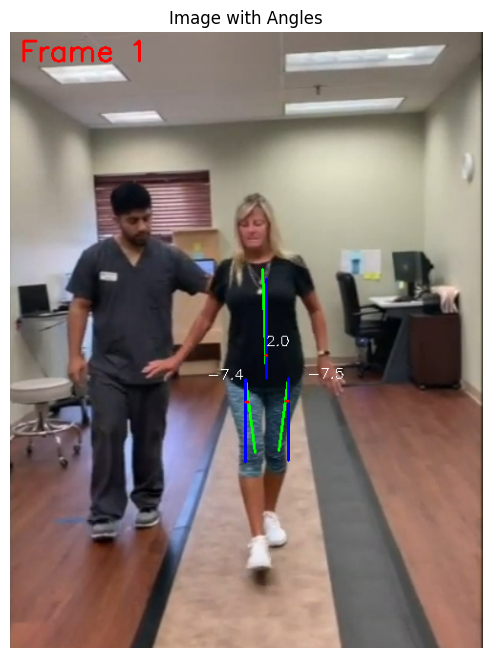

In [22]:
import numpy as np
import cv2
import csv
from tqdm.auto import tqdm
from PIL import Image
def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)


def is_between_vertical_lines(knee_point, left_hip_vertical, right_hip_vertical):
    # Check if the knee x-coordinate is between the x-coordinates of the two vertical lines
    x_min = min(left_hip_vertical[0], right_hip_vertical[0])
    x_max = max(left_hip_vertical[0], right_hip_vertical[0])
    return x_min <= knee_point[0] <= x_max


def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 0, 255), thickness=2):
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)
    
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1
    
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))
    
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)
    
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))
    
    return (text_x, text_y)

def calculate_text_parameters(frame_width, frame_height):
    """
    Calculate font size and thickness based on frame dimensions
    """
    # Calculate the diagonal size of the frame
    diagonal = np.sqrt(frame_width**2 + frame_height**2)
    
    # Scale font size based on diagonal (empirically determined ratios)
    font_scale = diagonal / 2000.0  # Adjust this divisor to change the base scale
    thickness = max(1, int(diagonal / 1000.0))  # Adjust this divisor to change the base thickness
    
    # Parameters for different text elements
    frame_number_params = {
        'font_scale': font_scale * 4,  # Slightly larger for frame number
        'thickness': thickness + 1,
        'margin_x': int(frame_width * 0.02),  # 2% margin from left
        'margin_y': int(frame_height * 0.05)   # 5% margin from top
    }
    
    angle_text_params = {
        'font_scale': font_scale * 0.8,  # Slightly smaller for angle values
        'thickness': thickness
    }
    
    line_thickness = max(1, int(diagonal / 800.0))  # For lines and arcs
    
    return frame_number_params, angle_text_params, line_thickness

def process_video(input_path, model, DcctorIsLeft=True):
    
    
    frame_number = 1
    frame = cv2.imread(input_path)
    # Alternative Method 2: Using cv2 function
    frame_height = frame.shape[0]  # rows (height)
    frame_width = frame.shape[1]   # columns (width)
    # Add frame number with dynamic font size and position
    cv2.putText(frame, 
                f"Frame {frame_number}",  # Text to display
                (10, 30),  # Position (x, y) - 10 pixels from left, 30 pixels from top
                cv2.FONT_HERSHEY_SIMPLEX,  # Font type
                1,  # Font scale (equivalent to font size)
                (0, 0, 255),  # Color (in BGR) - red in this case
                2)  # Thickness of the text
    
    if len(frame.shape) > 2 and frame.shape[2] == 4:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
    
    try:
        frame_keypoints = model.inference(frame)
    except Exception as e:
        print(f"Error processing frame {frame_number}: {str(e)}")


    final_frame_keypoints = frame_keypoints
    # print(frame_keypoints)
    print(len(final_frame_keypoints))

    if len(frame_keypoints) > 1:
        if DcctorIsLeft:
            if frame_keypoints[1][0][1] > frame_keypoints[0][0][1]:
                final_frame_keypoints = frame_keypoints[1]
            else:
                final_frame_keypoints = frame_keypoints[0]
        else:
            if frame_keypoints[1][0][1] < frame_keypoints[0][0][1]:
                final_frame_keypoints = frame_keypoints[1]
            else:
                final_frame_keypoints = frame_keypoints[0]
    else:
        final_frame_keypoints=frame_keypoints[0]
    print(final_frame_keypoints)
    frame_keypoints = final_frame_keypoints
    # Extract coordinates for points
    neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))
    hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))
    left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))
    right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))
    left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))
    right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))
    
    # Define vertical line points
    vertical_line_neck_point = (hip_point[0], neck_point[1]+10)
    left_vertical_line_point = (left_hip_point[0], left_knee_point[1]+10)
    right_vertical_line_point = (right_hip_point[0], right_knee_point[1]+10)
    
    
    
    line_thickness = 2
    # Draw the lines with dynamic thickness
    cv2.line(frame, hip_point, neck_point, (0, 255, 0), line_thickness)
    cv2.line(frame, left_hip_point, left_knee_point, (0, 255, 0), line_thickness)
    cv2.line(frame, right_hip_point, right_knee_point, (0, 255, 0), line_thickness)
    
    # Draw vertical lines
    cv2.line(frame, hip_point, vertical_line_neck_point, (255, 0, 0), line_thickness)
    cv2.line(frame, left_hip_point, left_vertical_line_point, (255, 0, 0), line_thickness)
    cv2.line(frame, right_hip_point, right_vertical_line_point, (255, 0, 0), line_thickness)
    
    # Calculate angles
    neck_angle = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
    left_angle = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
    right_angle = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

    # Adjust angle if greater than 180
    if neck_angle> 180:
        neck_angle= 360 - neck_angle
    if left_angle > 180:
        left_angle = 360 -left_angle
    if right_angle > 180:
        right_angle = 360 - right_angle

    # Adjust angle sign based on the knee's position relative to the vertical lines
    left_hip_vertical = (left_hip_point[0], left_knee_point[1])
    right_hip_vertical = (right_hip_point[0], right_knee_point[1])

    # For left knee
    if is_between_vertical_lines(left_knee_point, left_hip_vertical, right_hip_vertical):
        left_angle = -left_angle

    # For right knee
    if is_between_vertical_lines(right_knee_point, left_hip_vertical, right_hip_vertical):
        right_angle = -right_angle
    
    # Draw angle arcs and add text with dynamic size
    radius = int(min(frame_width, frame_height) * 0.05)  # Dynamic radius based on frame size
    text_pos = draw_angle_arc(frame, hip_point, neck_point, vertical_line_neck_point, 
                            radius=radius, thickness=line_thickness)
    
    cv2.putText(frame, f"{neck_angle:.1f}", text_pos,
        cv2.FONT_HERSHEY_SIMPLEX, 
        0.5, 
        (255, 255, 255), 
        1)

    
    text_pos = draw_angle_arc(frame, left_hip_point, left_knee_point, left_vertical_line_point, 
                            radius=radius, thickness=line_thickness)
    text_pos = (left_hip_point[0]+20, left_hip_point[1])  # Use knee point + 10
    cv2.putText(frame, f"{left_angle:.1f}", text_pos,
        cv2.FONT_HERSHEY_SIMPLEX, 
        0.5, 
        (255, 255, 255), 
        1)
    
    text_pos = draw_angle_arc(frame, right_hip_point, right_knee_point, right_vertical_line_point, 
                            radius=radius, thickness=line_thickness)
    text_pos = (right_hip_point[0]-40 , right_hip_point[1])  # Use knee point + 10
    cv2.putText(frame, f"{right_angle:.1f}", text_pos,
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5,  # Font scale equivalent to size 16
            (255, 255, 255),  # Navy blue in BGR 
            1)  # Thickness
    import matplotlib.pyplot as plt

    # frame = model.draw(show_yolo=False)   

    # Display the image
    plt.figure(figsize=(10, 8))  # Optional: set figure size
    plt.imshow(frame[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')  # Hide axis
    plt.title('Image with Angles')  # Optional: add a title
    plt.show()          

                


# Usage example
input_video_path = '/home/salam/frontal_gait/image.png'
file_name = input_video_path.split('/')[-1].split('.')[0]
output_video_path = f'/home/salam/frontal_gait/videos/{file_name}_oF2.mp4'
csv_output_path = f'/home/salam/frontal_gait/csvs/{file_name}.csv'

process_video(input_video_path, model)

In [28]:
import numpy as np
import cv2
import csv
from tqdm.auto import tqdm
from PIL import Image


def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)


def is_between_vertical_lines(knee_point, left_hip_vertical, right_hip_vertical):
    x_min = min(left_hip_vertical[0], right_hip_vertical[0])
    x_max = max(left_hip_vertical[0], right_hip_vertical[0])
    return x_min <= knee_point[0] <= x_max


def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 255, 0), thickness=2):
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)
    
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1
    
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))
    
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)
    
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))
    
    return (text_x, text_y)


def calculate_text_parameters(frame_width, frame_height):
    diagonal = np.sqrt(frame_width**2 + frame_height**2)
    font_scale = diagonal / 2000.0
    thickness = max(1, int(diagonal / 1000.0))
    frame_number_params = {
        'font_scale': font_scale * 4,
        'thickness': thickness + 1,
        'margin_x': int(frame_width * 0.02),
        'margin_y': int(frame_height * 0.05)
    }
    angle_text_params = {
        'font_scale': font_scale * 0.8,
        'thickness': thickness
    }
    line_thickness = max(1, int(diagonal / 800.0))
    return frame_number_params, angle_text_params, line_thickness


def process_video(input_path, output_path, csv_path, model, DcctorIsLeft=True):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(total_frames, fps, frame_width, frame_height)
    frame_number_params, angle_text_params, line_thickness = calculate_text_parameters(frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    with open(csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Frame', 'Neck_Angle', 'Left_Knee_Angle', 'Right_Knee_Angle'])
        frame_number = 0
        pbar = tqdm(total=total_frames, desc="Processing Video", unit="frame")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            cv2.putText(frame, 
                       f"Frame: {frame_number}", 
                       (frame_number_params['margin_x'], frame_number_params['margin_y']),
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       frame_number_params['font_scale'], 
                       (255, 255, 255), 
                       frame_number_params['thickness'])
            
            if len(frame.shape) > 2 and frame.shape[2] == 4:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)
            
            try:
                frame_keypoints = model.inference(frame)

                # Final keypoints selection logic
                final_frame_keypoints = (frame_keypoints[1] 
                                         if (DcctorIsLeft and frame_keypoints[1][0][1] > frame_keypoints[0][0][1]) 
                                         else frame_keypoints[0])
                frame_keypoints = final_frame_keypoints

                neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))
                hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))
                left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))
                right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))
                left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))
                right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))
                
                vertical_line_neck_point = (hip_point[0], neck_point[1])
                left_vertical_line_point = (left_hip_point[0], left_knee_point[1])
                right_vertical_line_point = (right_hip_point[0], right_knee_point[1])
                
                cv2.line(frame, hip_point, neck_point, (0, 255, 0), line_thickness)
                cv2.line(frame, left_hip_point, left_knee_point, (0, 255, 0), line_thickness)
                cv2.line(frame, right_hip_point, right_knee_point, (0, 255, 0), line_thickness)
                
                neck_angle = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
                left_angle = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
                right_angle = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

                if neck_angle > 180:
                    neck_angle = 360 - neck_angle
                if left_angle > 180:
                    left_angle = 360 - left_angle
                if right_angle > 180:
                    right_angle = 360 - right_angle
                
                radius = int(min(frame_width, frame_height) * 0.05)
                text_pos = draw_angle_arc(frame, hip_point, neck_point, vertical_line_neck_point, 
                                          radius=radius, thickness=line_thickness)
                cv2.putText(frame, f"{neck_angle:.1f}", text_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, 
                            angle_text_params['font_scale'], 
                            (255, 255, 255), 
                            angle_text_params['thickness'])

                csvwriter.writerow([frame_number, neck_angle, left_angle, right_angle])

            except Exception as e:
                csvwriter.writerow([frame_number, None, None, None])
            frame_number += 1
            out.write(frame)
            pbar.update(1)
        
        pbar.close()
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [69]:
import numpy as np
import cv2
import csv
from tqdm.auto import tqdm
from PIL import Image


def calculate_angle(point1, point2, vertical_point):
    line_to_joint = np.array(point2) - np.array(point1)
    line_to_vertical = np.array(vertical_point) - np.array(point1)
    dot_product = np.dot(line_to_joint, line_to_vertical)
    magnitude_line_to_joint = np.linalg.norm(line_to_joint)
    magnitude_line_to_vertical = np.linalg.norm(line_to_vertical)
    cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)
    angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle_radians)


def is_between_vertical_lines(knee_point, left_hip_vertical, right_hip_vertical):
    x_min = min(left_hip_vertical[0], right_hip_vertical[0])
    x_max = max(left_hip_vertical[0], right_hip_vertical[0])
    return x_min <= knee_point[0] <= x_max


def draw_angle_arc(img, vertex, point1, point2, radius=30, color=(0, 255, 0), thickness=2):
    v1 = np.array(point1) - np.array(vertex)
    v2 = np.array(point2) - np.array(vertex)
    
    angle1 = np.arctan2(v1[1], v1[0])
    angle2 = np.arctan2(v2[1], v2[0])
    
    if angle1 > angle2:
        angle1, angle2 = angle2, angle1
    
    start_angle = int(np.degrees(angle1))
    end_angle = int(np.degrees(angle2))
    
    cv2.ellipse(img, vertex, (radius, radius), 0, start_angle, end_angle, color, thickness)
    
    mid_angle = (angle1 + angle2) / 2
    text_x = int(vertex[0] + (radius + 10) * np.cos(mid_angle))
    text_y = int(vertex[1] + (radius + 10) * np.sin(mid_angle))
    
    return (text_x, text_y)


def calculate_text_parameters(frame_width, frame_height):
    diagonal = np.sqrt(frame_width**2 + frame_height**2)
    font_scale = diagonal / 2000.0
    thickness = max(1, int(diagonal / 1000.0))
    frame_number_params = {
        'font_scale': font_scale * 4,
        'thickness': thickness + 1,
        'margin_x': int(frame_width * 0.02),
        'margin_y': int(frame_height * 0.05)
    }
    angle_text_params = {
        'font_scale': font_scale * 0.8,
        'thickness': thickness
    }
    line_thickness = max(1, int(diagonal / 800.0))
    return frame_number_params, angle_text_params, line_thickness


def process_video(input_path, output_path, csv_path, model, DcctorIsLeft=True):
    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = min(720,int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)))
    frame_height = min(1280,int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frame_number_params, angle_text_params, line_thickness = calculate_text_parameters(frame_width, frame_height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    print(fps, frame_width, frame_height,total_frames,angle_text_params, line_thickness)

    with open(csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Frame', 'Spine Angle', 'Hip Angle Left', 'Hip Angle Right'])
        frame_number = 0
        pbar = tqdm(total=total_frames, desc="Processing Video", unit="frame")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (frame_width, frame_height))

            cv2.putText(frame, 
                       f"Frame: {frame_number}", 
                       (frame_number_params['margin_x'], frame_number_params['margin_y']),
                       cv2.FONT_HERSHEY_SIMPLEX, 
                       frame_number_params['font_scale'], 
                       (255, 255, 255), 
                       frame_number_params['thickness'])
            
            # Ensure the frame has 3 channels
            if len(frame.shape) > 2 and frame.shape[2] == 4:  # If 4 channels, discard the 4th
                frame = frame[:, :, :3]
            elif len(frame.shape) == 2:  # If single channel (grayscale), convert to 3 channels
                frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

            
            # try:
            frame_keypoints = model.inference(frame)

            # Final keypoints selection logic
            # print(len(frame_keypoints))
            if(len(frame_keypoints)>1):
                final_frame_keypoints = (frame_keypoints[1] 
                                            if (DcctorIsLeft and frame_keypoints[1][0][1] > frame_keypoints[0][0][1]) 
                                            else frame_keypoints[0])
            else:
                final_frame_keypoints = frame_keypoints[0]
            frame_keypoints = final_frame_keypoints

            neck_point = (int(frame_keypoints[5][1]), int(frame_keypoints[5][0]))
            hip_point = (int(frame_keypoints[14][1]), int(frame_keypoints[14][0]))
            left_hip_point = (int(frame_keypoints[12][1]), int(frame_keypoints[12][0]))
            right_hip_point = (int(frame_keypoints[13][1]), int(frame_keypoints[13][0]))
            left_knee_point = (int(frame_keypoints[15][1]), int(frame_keypoints[15][0]))
            right_knee_point = (int(frame_keypoints[16][1]), int(frame_keypoints[16][0]))
            
            vertical_line_neck_point = (hip_point[0], neck_point[1])
            left_vertical_line_point = (left_hip_point[0], left_knee_point[1])
            right_vertical_line_point = (right_hip_point[0], right_knee_point[1])
            
            # Draw all lines
            cv2.line(frame, hip_point, neck_point, (0, 255, 0), line_thickness)
            cv2.line(frame, left_hip_point, left_knee_point, (0, 255, 0), line_thickness)
            cv2.line(frame, right_hip_point, right_knee_point, (0, 255, 0), line_thickness)
            cv2.line(frame, hip_point, vertical_line_neck_point, (255, 0, 0), line_thickness)
            cv2.line(frame, left_hip_point, left_vertical_line_point, (255, 0, 0), line_thickness)
            cv2.line(frame, right_hip_point, right_vertical_line_point, (255, 0, 0), line_thickness)
            
            # Calculate angles
            neck_angle = calculate_angle(hip_point, neck_point, vertical_line_neck_point)
            left_angle = calculate_angle(left_hip_point, left_knee_point, left_vertical_line_point)
            right_angle = calculate_angle(right_hip_point, right_knee_point, right_vertical_line_point)

            if neck_angle > 180:
                neck_angle = 360 - neck_angle
            if left_angle > 180:
                left_angle = 360 - left_angle
            if right_angle > 180:
                right_angle = 360 - right_angle

            radius = int(min(frame_width, frame_height) * 0.05)
            
            # Adjust angle sign based on the knee's position relative to the vertical lines
            left_hip_vertical = (left_hip_point[0], left_knee_point[1])
            right_hip_vertical = (right_hip_point[0], right_knee_point[1])
            # For left knee
            if is_between_vertical_lines(left_knee_point, left_hip_vertical, right_hip_vertical):
                left_angle = -left_angle

            # For right knee
            if is_between_vertical_lines(right_knee_point, left_hip_vertical, right_hip_vertical):
                right_angle = -right_angle
            # Neck angle
            text_pos = draw_angle_arc(frame, hip_point, neck_point, vertical_line_neck_point, 
                                        radius=radius, thickness=line_thickness)
            cv2.putText(frame, f"{neck_angle:.1f}", text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        angle_text_params['font_scale'], 
                        (255, 255, 255), 
                        angle_text_params['thickness'])

            # Left knee angle
            text_pos = draw_angle_arc(frame, left_hip_point, left_knee_point, left_vertical_line_point, 
                                        radius=radius, thickness=line_thickness)
            # text_pos[0]+=20
            text_pos = (left_hip_point[0]+20 , left_hip_point[1])  # Use knee point + 10
            cv2.putText(frame, f"{left_angle:.1f}", text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        angle_text_params['font_scale'], 
                        (255, 255, 255), 
                        angle_text_params['thickness'])

            # Right knee angle
            text_pos = draw_angle_arc(frame, right_hip_point, right_knee_point, right_vertical_line_point, 
                                        radius=radius, thickness=line_thickness)
            # text_pos[0]-=20
            text_pos = (right_hip_point[0]-40 , right_hip_point[1])  # Use knee point + 10
            cv2.putText(frame, f"{right_angle:.1f}", text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        angle_text_params['font_scale'], 
                        (255, 255, 255), 
                        angle_text_params['thickness'])

            csvwriter.writerow([frame_number, neck_angle, left_angle, right_angle])
            
            
            if frame_number%100 == 0:
                print(frame_keypoints)
                import matplotlib.pyplot as plt
                plt.figure(figsize=(10, 8))  # Optional: set figure size
                plt.imshow(frame[..., ::-1])  # Convert BGR to RGB
                plt.axis('off')  # Hide axis
                plt.title('Image with Angles')  # Optional: add a title
                plt.show()          

            # except Exception as e:
            #     print(f"error-{e}")
            #     csvwriter.writerow([frame_number, None, None, None])
            frame_number += 1

            out.write(frame)
            pbar.update(1)
        
        pbar.close()
    
    cap.release()
    out.release()
    cv2.destroyAllWindows()


filename: Selina_front
30 720 1280 447 {'font_scale': 0.5874419120219463, 'thickness': 1} 1


Processing Video:   0%|          | 0/447 [00:00<?, ?frame/s]

[[     348.32      385.79      1.0052]
 [     343.99      391.37     0.97503]
 [     343.78      380.26      0.9731]
 [     348.59      399.23     0.96158]
 [     347.42       372.4     0.95804]
 [     380.12      384.97      1.0116]
 [     379.21      409.73     0.97196]
 [     380.43      360.47     0.96824]
 [     418.86      416.03     0.95402]
 [     420.74      352.87     0.95657]
 [     453.29       415.9     0.96177]
 [     455.52      350.61     0.96486]
 [     455.37      401.48     0.86733]
 [     456.33      370.02     0.85487]
 [     456.03      385.12     0.88689]
 [      510.6      400.15     0.92733]
 [      510.4       372.2     0.92212]
 [     566.06      398.19     0.92137]
 [     566.86      375.11     0.91894]
 [      580.2      398.67     0.83081]
 [     577.51      405.11      0.8791]
 [     572.84      395.86     0.79809]
 [     579.64      375.81     0.89548]
 [     578.53      369.53     0.92326]
 [     573.34      377.67     0.82948]]


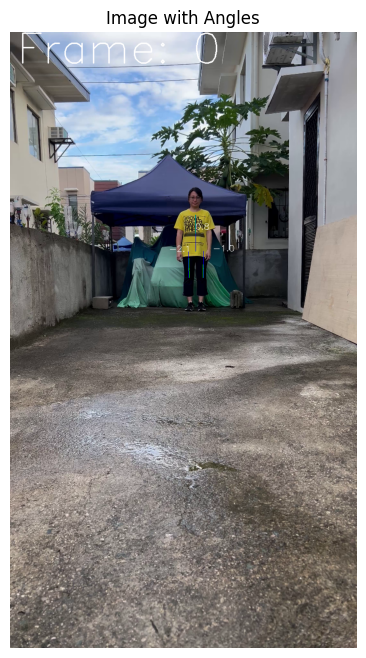

[[     225.22      388.27     0.97235]
 [     216.48      398.24     0.97105]
 [     215.45      377.57      0.9542]
 [     224.58      411.38     0.96737]
 [     222.19      361.82     0.93793]
 [     285.21      385.12      1.0153]
 [     283.39       431.3      0.9817]
 [     287.14      339.46      0.9543]
 [     347.65      446.47     0.96246]
 [     365.58      328.12     0.96106]
 [     397.43      457.65     0.94827]
 [     436.82      319.65     0.95349]
 [     420.45      418.06     0.85003]
 [     418.68      359.52     0.84224]
 [     419.98      388.26     0.88001]
 [     528.37      414.42     0.94395]
 [     522.56       369.7     0.93584]
 [     590.73      420.14     0.95409]
 [     632.32      372.67     0.91518]
 [     628.36      414.93     0.92255]
 [     624.54      429.72     0.93869]
 [      591.5      419.49     0.87692]
 [     659.48      369.75     0.89033]
 [     657.53       359.2     0.89848]
 [     644.32       379.2     0.84272]]


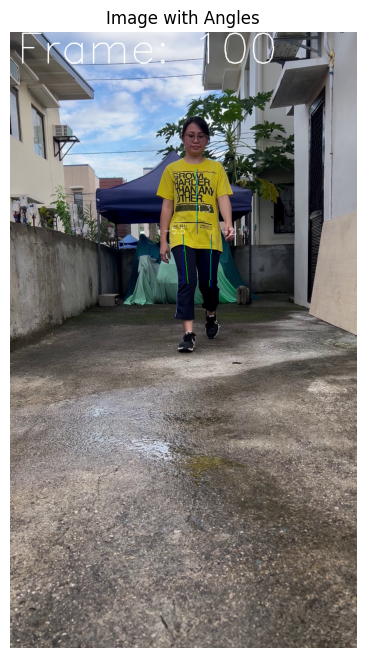

[[     533.63      227.73    0.037604]
 [     543.84      223.57    0.043221]
 [     555.29      230.99    0.037404]
 [     680.74      348.17    0.048196]
 [     557.46      229.84    0.026439]
 [    -3.6712      487.54      0.2245]
 [    -9.1168      342.67     0.28055]
 [     74.063      606.94     0.31043]
 [     820.84       616.6     0.23947]
 [      972.3      639.25     0.18349]
 [     303.58      253.37     0.11674]
 [    -10.186      729.53    0.098433]
 [     154.37      349.08     0.32339]
 [     80.199      607.13     0.37143]
 [      82.97      483.65     0.31904]
 [     841.28      564.97     0.84343]
 [      978.7       661.4     0.71849]
 [     1290.2      336.68     0.29905]
 [       1289      341.91    0.053847]
 [     1272.7      486.07      0.1775]
 [     1271.9       477.6     0.11342]
 [     1289.1      290.51     0.30919]
 [     1290.1         296     0.03422]
 [     1291.1      293.33    0.030609]
 [     1289.9      382.03    0.050648]]


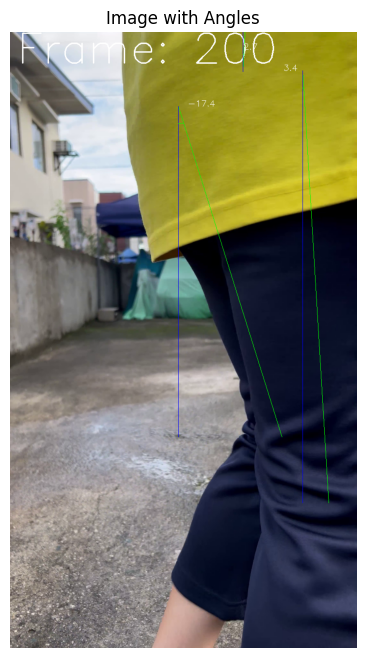

/tmp/ipykernel_20026/1144311111.py:14: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (magnitude_line_to_joint * magnitude_line_to_vertical)


[[     221.36       375.4      0.7194]
 [     211.97       374.1     0.77074]
 [     210.19       383.5     0.54586]
 [     214.75      373.47     0.95894]
 [     210.73      428.32     0.94323]
 [     280.93      405.95      1.0462]
 [     282.04      349.88      0.9578]
 [     279.77      459.57     0.93819]
 [      377.9      336.19     0.95215]
 [     367.48      476.59     0.96245]
 [     438.11      338.95      0.9574]
 [     446.01      489.81     0.95438]
 [      456.1      374.92     0.86608]
 [      452.2      443.66     0.89309]
 [      454.9      409.02     0.92879]
 [     565.09      387.13     0.91193]
 [      553.4      440.77     0.96014]
 [     688.96      399.41     0.92093]
 [        655      439.47     0.90579]
 [     699.69      391.74     0.76147]
 [     703.92       385.8     0.74489]
 [     710.49      405.84     0.93945]
 [     695.78      448.97     0.75028]
 [      692.3      455.92     0.72494]
 [     669.87       434.6     0.83397]]


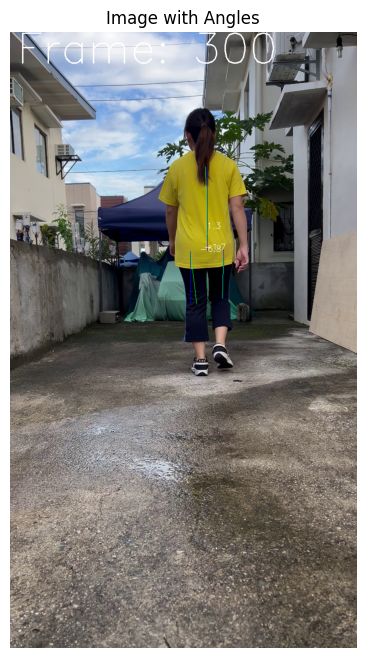

[[     371.78      372.35     0.67507]
 [     367.68      371.63     0.70906]
 [     365.69      379.02     0.53801]
 [     370.57      371.73     0.99771]
 [     368.36      397.93     0.97232]
 [     400.88      390.28      1.0438]
 [     402.76       364.6     0.95386]
 [     399.54      416.06     0.94485]
 [     447.03       360.6     0.95409]
 [     442.01      423.08     0.96924]
 [     481.37      360.33     0.95364]
 [     478.79      426.21      0.9449]
 [     483.37      377.49     0.88136]
 [     480.86      409.78     0.89007]
 [     482.53      393.38     0.94458]
 [     533.55      382.07     0.93907]
 [     530.35      408.74     0.95013]
 [     589.13      386.64     0.93626]
 [     571.07       411.1      0.8745]
 [     595.64      381.99      0.8384]
 [     596.18      380.52      0.8104]
 [     596.95      389.67     0.93131]
 [     594.02      414.59     0.79097]
 [     592.16      418.39     0.73831]
 [     577.82      410.18     0.80092]]


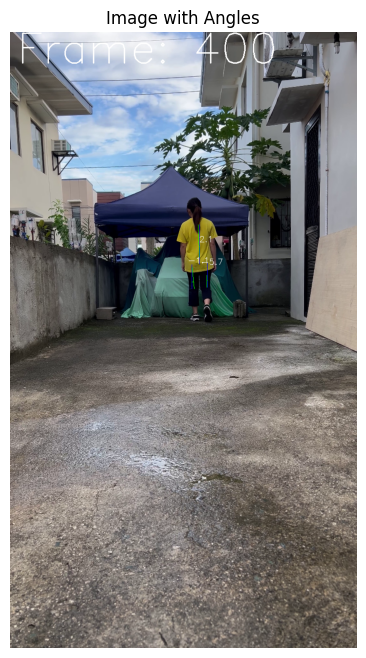

In [70]:
# Usage example
input_video_path = '/home/salam/frontal_gait/videos/Selina_front.mp4'
file_name = input_video_path.split('/')[-1].split('.')[0]
print(f"filename: {file_name}")
output_video_path = f'/home/salam/frontal_gait/videos/{file_name}_oF2.mp4'
csv_output_path = f'/home/salam/frontal_gait/csvs/{file_name}2.csv'

process_video(input_video_path, output_video_path, csv_output_path, model, DcctorIsLeft=True)

In [29]:
import qrcode

def generate_vcard_qr(name, phone_numbers, emails, location,website, image_path, output_path):
    # Construct the vCard string
    vcard = f"BEGIN:VCARD\nVERSION:3.0\nFN:{name}\n"
    
    # Add multiple phone numbers
    for phone, phone_type in phone_numbers:
        vcard += f"TEL;TYPE={phone_type.upper()}:{phone}\n"

    # Add multiple emails
    for email, email_type in emails:
        vcard += f"EMAIL;TYPE={email_type.upper()}:{email}\n"

    # Add location
    if location:
        address = f"{location.get('street', '')};{location.get('city', '')};{location.get('region', '')};{location.get('postal_code', '')};{location.get('country', '')}"
        vcard += f"ADR;TYPE=HOME:;;{address}\n"
    # Add website
    if website:
        vcard += f"URL:{website}\n"
    # Add photo if available (referencing the image in QR-based vCards is tricky, this step is optional)
    if image_path:
        with open(image_path, 'rb') as img_file:
            photo_base64 = img_file.read().encode("base64").decode()
        vcard += f"PHOTO;ENCODING=BASE64;TYPE=JPEG:{photo_base64}\n"

    vcard += "END:VCARD"

    # Generate the QR code
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )
    qr.add_data(vcard)
    qr.make(fit=True)

    # Save the QR code as an image
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(output_path)

    print(f"QR code saved to {output_path}")

# Example usage
generate_vcard_qr(
    name="Abdus Salam",
    phone_numbers=[("+8801791373638", "CELL"), ("+8801303615199", "WORK")],
    emails=[("salam35.ruet17@gmail.com", "INTERNET"), ("asalam@mymedicalhub.com", "WORK")],
    location={
        "street": "Level-8, J-28/8 D, Haque Tower,Bir Uttam AK Khandakar Rd",
        "city": "Dhaka",
        "region": "IL",
        "postal_code": "62704",
        "country": "Bangladesh"
    },
    website="www.mymedicalhub.com",
    image_path=None,  # Path to the image if embedding the photo
    output_path="vcard_qr.png"  # Output QR code image file
)


QR code saved to vcard_qr.png


In [24]:
!pip install qrcode[pil]


In [3]:
import base64
import qrcode

def generate_vcard_qr(name, phone_numbers, emails, location, website=None, image_path=None, output_path="vcard_qr.png"):
    # Construct the vCard string
    vcard = f"BEGIN:VCARD\nVERSION:3.0\nFN:{name}\n"
    
    # Add multiple phone numbers
    for phone, phone_type in phone_numbers:
        vcard += f"TEL;TYPE={phone_type.upper()}:{phone}\n"

    # Add multiple emails
    for email, email_type in emails:
        vcard += f"EMAIL;TYPE={email_type.upper()}:{email}\n"

    # Add location
    if location:
        address = f"{location.get('street', '')};{location.get('city', '')};{location.get('region', '')};{location.get('postal_code', '')};{location.get('country', '')}"
        vcard += f"ADR;TYPE=HOME:;;{address}\n"

    # Add website
    if website:
        vcard += f"URL:{website}\n"

    # Optionally embed photo (may increase QR code size)
    if image_path:
        with open(image_path, 'rb') as img_file:
            photo_base64 = base64.b64encode(img_file.read()).decode('utf-8')
        vcard += f"PHOTO;ENCODING=BASE64;TYPE=JPEG:{photo_base64}\n"

    vcard += "END:VCARD"

    # Generate the QR code
    qr = qrcode.QRCode(
        error_correction=qrcode.constants.ERROR_CORRECT_L,  # Error correction level
        box_size=10,
        border=4,
    )
    qr.add_data(vcard)
    qr.make(fit=True)  # Automatically adjust the QR code size

    # Save the QR code as an image
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(output_path)

    print(f"QR code saved to {output_path}")

# Example usage
generate_vcard_qr(
    name="Abdus Salam",
    phone_numbers=[("+8801791373638", "CELL"), ("+8801303615199", "WORK")],
    emails=[("asalam@mymedicalhub.com", "WORK"),("salam35.ruet17@gmail.com", "INTERNET")],
    location={
        "street": "Level-8, J-28/8 D, Haque Tower, Bir Uttam AK Khandakar Rd",
        "city": "Dhaka",
        "postal_code": "62704",
        "country": "Bangladesh"
    },
    website="www.mymedicalhub.com",
    # Set image_path=None to skip embedding the photo for smaller QR codes
    image_path=None,
    output_path="vcard_qr.png"
)


QR code saved to vcard_qr.png


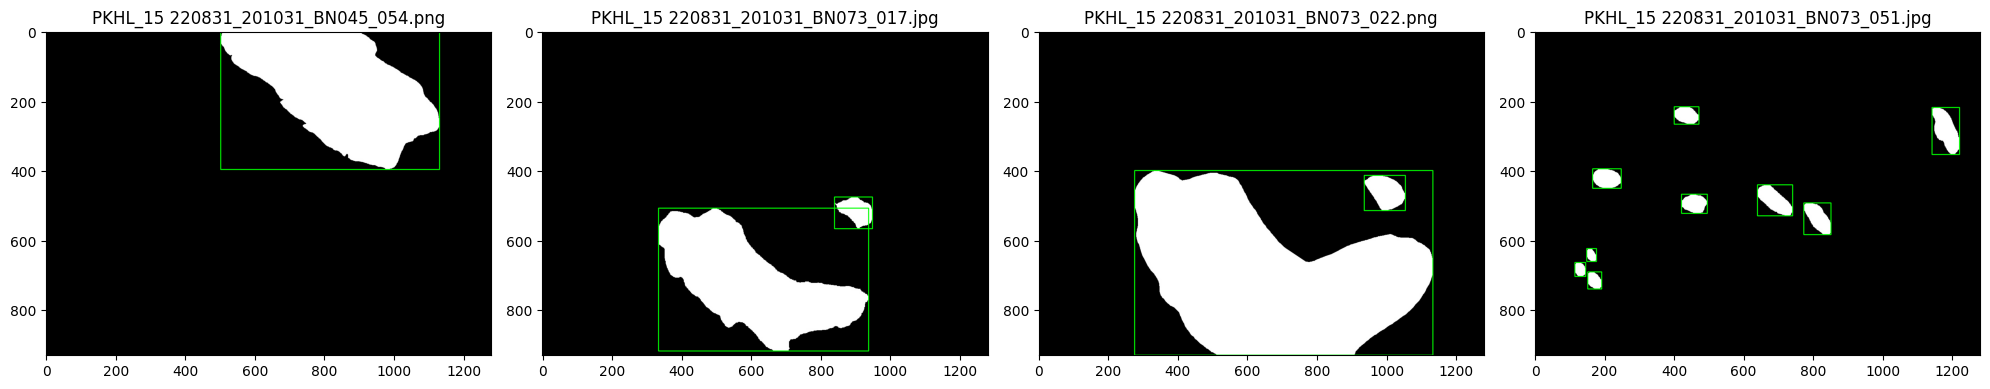

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set the image directory
image_dir = '/media/salam/Salam/MSc/PolypDB/img/'

# Function to process and visualize masks with bounding boxes
def process_mask_images(directory):
    # Get all files in the directory
    mask_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    
    # Calculate grid dimensions
    n_images = len(mask_files)
    n_cols = 4  # You can adjust this
    n_rows = (n_images + n_cols - 1) // n_cols
    
    # Create a figure with subplots
    plt.figure(figsize=(20, 5 * n_rows))
    
    # Process each mask image
    for i, filename in enumerate(mask_files, 1):
        # Full path to the image
        filepath = os.path.join(directory, filename)
        
        # Read the image
        mask = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        
        # Threshold to create binary image (in case it's not already binary)
        _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Convert to color for drawing
        color_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        
        # Draw bounding boxes
        for contour in contours:
            # Filter out very small contours (noise)
            if cv2.contourArea(contour) > 50:  # Adjust this threshold as needed
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(color_mask, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Plot in subplot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
        plt.title(filename)
        plt.axis('on')
    
    plt.tight_layout()
    plt.show()

# Run the processing
process_mask_images(image_dir)

In [2]:
import os
import cv2
import numpy as np

# Directories
image_dir = '/media/salam/Salam/MSc/PolypDB/img/'
label_dir = '/media/salam/Salam/MSc/PolypDB/labels/'

# Create labels directory if it doesn't exist
os.makedirs(label_dir, exist_ok=True)

# Function to generate YOLO format labels
def generate_yolo_labels(directory):
    # Get all files in the directory
    mask_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    
    # Process each mask image
    for filename in mask_files:
        # Full path to the image
        filepath = os.path.join(directory, filename)
        
        # Read the image
        mask = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        
        # Get image dimensions
        height, width = mask.shape
        
        # Threshold to create binary image
        _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Prepare label file path (change extension to .txt)
        label_filename = os.path.splitext(filename)[0] + '.txt'
        label_filepath = os.path.join(label_dir, label_filename)
        
        # Open label file to write
        with open(label_filepath, 'w') as label_file:
            # Process each contour
            for contour in contours:
                # Filter out very small contours (noise)
                if cv2.contourArea(contour) > 50:  # Adjust threshold as needed
                    # Get bounding rectangle
                    x, y, w, h = cv2.boundingRect(contour)
                    
                    # YOLO format:
                    # <class> <x_center> <y_center> <width> <height>
                    # All values normalized to [0, 1]
                    x_center = (x + w/2) / width
                    y_center = (y + h/2) / height
                    width_norm = w / width
                    height_norm = h / height
                    
                    # Write label (class 0, normalized coordinates)
                    label_file.write(f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
        print(f"Generated labels for {filename}")

# Run the label generation
generate_yolo_labels(image_dir)

print(f"YOLO labels have been saved to {label_dir}")

Generated labels for PKHL_15 220831_201031_BN045_054.png
Generated labels for PKHL_15 220831_201031_BN073_017.jpg
Generated labels for PKHL_15 220831_201031_BN073_022.png
Generated labels for PKHL_15 220831_201031_BN073_051.jpg
YOLO labels have been saved to /media/salam/Salam/MSc/PolypDB/labels/


In [ ]:
import os
import shutil
import cv2
import numpy as np

# Directories
base_dirs = '/media/salam/Salam/MSc/PolypDB/PolypDB/PolypDB_modality_wise/'
dataset_dir = '/media/salam/Salam/MSc/PolypDB/yolo_dataset/'

# Create dataset subdirectories
images_dir = os.path.join(dataset_dir, 'images')
labels_dir = os.path.join(dataset_dir, 'labels')

# Create directories
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Function to prepare YOLO dataset
def prepare_yolo_dataset(image_dir,directory):
    # Get all files in the directory
    mask_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    
    # Process each mask image
    for filename in mask_files:
        # Full path to the input image
        filepath = os.path.join(directory, filename)
        file_name = filepath.split('/')[-1].split('.')[0]+".jpg"
        # print(image_dir,file_name)
        image_path = os.path.join(image_dir,file_name)
        
        # Read the image
        mask = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path)
        # Get image dimensions
        height, width = mask.shape
        
        # Threshold to create binary image
        _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Prepare paths for dataset
        label_filename = os.path.splitext(filename)[0] + '.txt'
        image_dest_path = os.path.join(images_dir, filename)
        label_dest_path = os.path.join(labels_dir, label_filename)
        
        # Copy original image to images folder
        shutil.copy2(image_path, image_dest_path)
        
        # Open label file to write
        with open(label_dest_path, 'w') as label_file:
            # Process each contour
            for contour in contours:
                # Filter out very small contours (noise)
                if cv2.contourArea(contour) > 50:  # Adjust threshold as needed
                    # Get bounding rectangle
                    x, y, w, h = cv2.boundingRect(contour)
                    
                    # YOLO format:
                    # <class> <x_center> <y_center> <width> <height>
                    # All values normalized to [0, 1]
                    x_center = (x + w/2) / width
                    y_center = (y + h/2) / height
                    width_norm = w / width
                    height_norm = h / height
                    
                    # Write label (class 0, normalized coordinates)
                    label_file.write(f"0 {x_center:.6f} {y_center:.6f} {width_norm:.6f} {height_norm:.6f}\n")
        
        print(f"Processed {filename}")
    
    # Create dataset.yaml for YOLO
    create_dataset_yaml()

# Function to create dataset.yaml
def create_dataset_yaml():
    yaml_path = os.path.join(dataset_dir, 'dataset.yaml')
    with open(yaml_path, 'w') as yaml_file:
        yaml_file.write(f"""train: {images_dir}
val: {images_dir}
test: {images_dir}

nc: 1
names: ['polyp']
""")
    print(f"Created dataset.yaml at {yaml_path}")

# Run the dataset preparation
for dirs in os.listdir(base_dirs):
    input_image_dir = os.path.join(base_dirs, dirs, 'images')
    input_mask_dir = os.path.join(base_dirs, dirs, 'masks')
    # print(f"Running dataset: {input_image_dir}")
    prepare_yolo_dataset(input_image_dir,input_mask_dir)

print(f"YOLO dataset has been prepared in {dataset_dir}")

# Optional: Print dataset statistics
total_images = len(os.listdir(images_dir))
total_labels = len(os.listdir(labels_dir))
print(f"\nDataset Statistics:")
print(f"Total Images: {total_images}")
print(f"Total Label Files: {total_labels}")

In [ ]:
!pip install ultralytics

In [ ]:
import os
import torch
from ultralytics import YOLO
from pathlib import Path

def evaluate_yolo_model(
    weights_path='/media/salam/Salam/MSc/PolypDB/polyp_yolov8x/weights/best.pt', 
    data_yaml='/media/salam/Salam/MSc/PolypDB/yolo_dataset/dataset.yaml',
    output_dir=None
):
    """
    Evaluate a YOLO model and save predictions and performance metrics.
    
    Args:
        weights_path (str): Path to the trained model weights
        data_yaml (str): Path to the dataset configuration file
        output_dir (str, optional): Directory to save predictions and results
    """
    # Create output directory if not specified
    if output_dir is None:
        output_dir = os.path.join(
            os.path.dirname(weights_path), 
            'evaluation_results'
        )
    os.makedirs(output_dir, exist_ok=True)

    # Prediction directories
    pred_images_dir = os.path.join(output_dir, 'predicted_images')
    pred_labels_dir = os.path.join(output_dir, 'predicted_labels')
    os.makedirs(pred_images_dir, exist_ok=True)
    os.makedirs(pred_labels_dir, exist_ok=True)

    # Load the model
    model = YOLO(weights_path)

    # Perform evaluation
    print("Starting model evaluation...")
    results = model.val(
        data=data_yaml, 
        save_json=True,  # Save COCO JSON results
        # save_hybrid=True,  # Save hybrid version of predictions
        conf=0.25,  # Confidence threshold
        iou=0.45,   # IoU threshold
        save_dir=output_dir,
        plots=True  # Save confusion matrix, PR curves etc.
    )

    # Save performance metrics to a text file
    with open(os.path.join(output_dir, 'evaluation_metrics.txt'), 'w') as f:
        f.write("YOLO Model Evaluation Metrics\n")
        f.write("=" * 30 + "\n")
        f.write(f"Model: {weights_path}\n")
        f.write(f"Dataset: {data_yaml}\n\n")
        f.write("Performance Metrics:\n")
        f.write(f"mAP50: {results.box.map:.4f}\n")
        f.write(f"mAP50-95: {results.box.map95:.4f}\n")
        f.write(f"Precision: {results.box.p:.4f}\n")
        f.write(f"Recall: {results.box.r:.4f}\n")

    # Run inference to save individual predictions
    print("Generating prediction images and labels...")
    for img_path in Path(data_yaml).parent.glob('**/val/*.jpg'):
        # Predict on the image
        pred_results = model(img_path, save=True, save_txt=True, 
                             project=pred_images_dir, 
                             name='predictions', 
                             exist_ok=True)
        
        # Copy prediction labels to labels directory
        img_name = os.path.splitext(img_path.name)[0]
        label_txt = img_path.parent / f'{img_name}.txt'
        if label_txt.exists():
            pred_label_path = os.path.join(pred_labels_dir, f'{img_name}.txt')
            with open(label_txt, 'r') as src, open(pred_label_path, 'w') as dst:
                dst.write(src.read())

    print(f"Evaluation complete. Results saved in {output_dir}")

def main():
    evaluate_yolo_model()

if __name__ == '__main__':
    main()

Starting model evaluation...
WARNING ⚠️ 'save_hybrid=True' will append ground truth to predictions for autolabelling.
WARNING ⚠️ 'save_hybrid=True' will cause incorrect mAP.

Ultralytics 8.3.25 🚀 Python-3.10.15 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i5-11400 2.60GHz)
Model summary (fused): 268 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 3.00MB/s]
val: Scanning /media/salam/Salam/MSc/PolypDB/yolo_dataset/labels... 3929 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3929/3929 [00:01<00:00, 2840.56it/s]


val: New cache created: /media/salam/Salam/MSc/PolypDB/yolo_dataset/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 18/246 [03:25<43:18, 11.40s/it]


KeyboardInterrupt: 